<a href="https://colab.research.google.com/github/vhrique/anne_ptbr/blob/development/projetos/CMAPSS_RUL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Data loading

In [ ]:
df = pd.read_parquet('https://drive.google.com/uc?export=download&id=1R7yQshjMkB2nFZ1OMM__EnIoKvihLrZq')
df.head()

,unit,cycle,cond_1,cond_2,cond_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,filename,group,RUL,cycle_max,split
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,392.0,2388.0,100.0,39.06,23.4190,train_FD001.txt,1,191,192,train
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,392.0,2388.0,100.0,39.00,23.4236,train_FD001.txt,1,190,192,train
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,390.0,2388.0,100.0,38.95,23.3442,train_FD001.txt,1,189,192,train
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,392.0,2388.0,100.0,38.88,23.3739,train_FD001.txt,1,188,192,train
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,393.0,2388.0,100.0,38.90,23.4044,train_FD001.txt,1,187,192,train


In [ ]:
dev_df = df.query('split == "train"')
test_df = df.query('split == "test"')

In [ ]:
train_df = dev_df.query('group == 1 and unit > 10')
val_df = dev_df.query('group == 1 and unit <= 10')
test_df = test_df.query('group == 1')

# Exploratory Data Analysis

In [ ]:
# Add any EDA code here

# Data Preprocessing

In [ ]:
def normalize_data(df, columns, data_max=None, data_min=None):
    new_df = df.copy()
    if data_max is None:
        data_max = new_df[columns].max()
    if data_min is None:
        data_min = new_df[columns].min()
    new_df.loc[:, columns] = (new_df[columns] - data_min)/(data_max - data_min)
    new_df = new_df.fillna(0)
    return new_df, data_max, data_min

In [ ]:
experiment_columns = ['group', 'unit', 'cycle']
condition_columns = [f'cond_{i+1}' for i in range(3)]
sensor_columns = [f'sensor_{i+1}' for i in range(21)]
feature_columns = condition_columns + sensor_columns
column_names = feature_columns + experiment_columns

train_df_norm, data_max, data_min = normalize_data(train_df, feature_columns)
val_df_norm, _, _ = normalize_data(val_df, feature_columns, data_max, data_min)
test_df_norm, _, _ = normalize_data(test_df, feature_columns, data_max, data_min)

# Modelling

## Pytorch Dataloader

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, feature_columns, unit_column, group_column, target_column, sequence_length=30, step_size=1):
        self.df = df.copy()
        self.feature_columns = feature_columns
        self.unit_column = unit_column
        self.group_column = group_column
        self.target_column = target_column
        self.sequence_length = sequence_length
        self.step_size = step_size

        # Group by unit and group
        self.grouped_data = self.df.groupby([group_column, unit_column])

        # Store the start indices for each unit's sequences
        self.indices = self._compute_indices()

    def _compute_indices(self):
        """
        Computes start indices for each unit's time series, based on the step size and sequence length.
        """
        indices = []
        for (group, unit), unit_data in self.grouped_data:
            unit_data_length = len(unit_data)
            # Compute the valid start indices for each time series
            num_samples = (unit_data_length - self.sequence_length) // self.step_size + 1
            for i in range(num_samples):
                start_idx = i * self.step_size
                indices.append((group, unit, start_idx))
        return indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        """
        Retrieves the sample at the given index. Dynamically extracts the sequence from the data.
        """
        group, unit, start_idx = self.indices[idx]
        unit_data = self.grouped_data.get_group((group, unit))  # Retrieve the specific time series

        # Extract the features for the sequence
        features = unit_data[self.feature_columns].values[start_idx:start_idx + self.sequence_length].T
        rul = unit_data[self.target_column].values[start_idx + self.sequence_length - 1].astype(int)
        return torch.tensor(features, dtype=torch.float32), torch.tensor(min(150,rul.item()), dtype=torch.float32)

In [ ]:
sequence_length = 30

In [ ]:
train_dataset = TimeSeriesDataset(train_df_norm, feature_columns, 'unit', 'group', 'RUL', sequence_length)
val_dataset = TimeSeriesDataset(val_df_norm, feature_columns, 'unit', 'group', 'RUL', sequence_length)
test_dataset = TimeSeriesDataset(test_df_norm, feature_columns, 'unit', 'group', 'RUL', sequence_length)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

## ANN Models

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_channels, sequence_length=30, hidden_size=64):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_channels,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=0.0,
            bidirectional=False
        )
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        lstm_out, (hn, cn) = self.lstm(x)
        x = lstm_out[:, -1, :]
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, input_channels, sequence_length=30, hidden_size=128):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_channels * sequence_length, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training and Evaluation Loops

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0.0
    for i, (inputs, labels) in enumerate(loader):
        # Forward pass
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.unsqueeze(-1).to(device))
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Loss logs
        epoch_loss += loss.item()/len(loader)
    return epoch_loss

In [ ]:
@torch.no_grad()
def validate_epoch(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.unsqueeze(-1).to(device))
        # Loss logs
        epoch_loss += loss.item()/len(train_loader)
    return epoch_loss

 33%|███▎      | 1/3 [00:25<00:50, 25.24s/it]

Epoch [1/3], Train Loss: 2984.2286, Val Loss: 1207.0575


 67%|██████▋   | 2/3 [00:50<00:25, 25.03s/it]

Epoch [2/3], Train Loss: 950.1529, Val Loss: 926.9662


100%|██████████| 3/3 [01:15<00:00, 25.10s/it]

Epoch [3/3], Train Loss: 818.6079, Val Loss: 768.6407


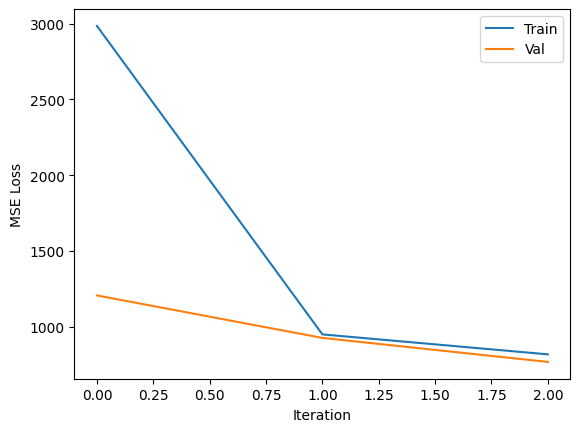

In [ ]:
# model = LSTMModel(input_channels=len(feature_columns), sequence_length=sequence_length).to(device)
model = MLPModel(input_channels=len(feature_columns), sequence_length=sequence_length).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 3
train_epoch_loss = []
val_epoch_loss = []
for epoch in tqdm(range(epochs), total=epochs):
    model.train()
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate_epoch(model, val_loader, criterion, device)
    train_epoch_loss.append(train_loss)
    val_epoch_loss.append(val_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

plt.plot(train_epoch_loss)
plt.plot(val_epoch_loss)
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.legend(['Train', 'Val'])
plt.show()

# Evaluation on Full Unit

In [ ]:
@torch.no_grad()
def evaluate_full(model, loader, device):
    model.eval()
    labels = []
    predictions = []
    for i, (inputs, targets) in enumerate(loader):
        # Forward pass
        outputs = model(inputs.to(device))
        labels.extend(targets.tolist())
        predictions.extend(outputs.detach().cpu().tolist())
    return labels, predictions

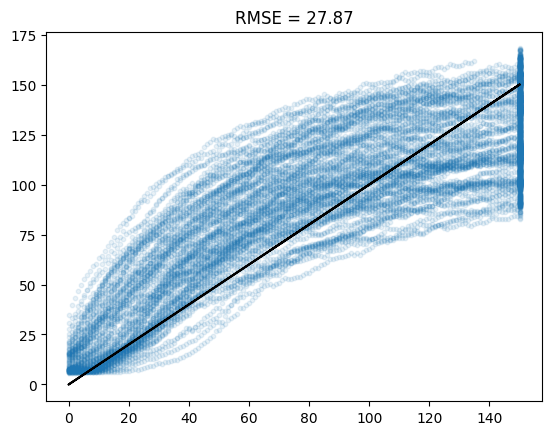

In [ ]:
y_train, yh_train = evaluate_full(model, train_loader, device)

plt.scatter(y_train, yh_train, s=10, alpha=0.1)
plt.plot(y_train, y_train, 'k')
plt.title(f'RMSE = {np.sqrt(mean_squared_error(y_train, yh_train)):.2f}')
plt.show()

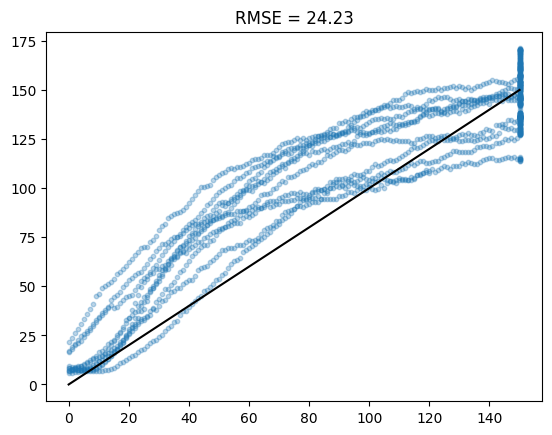

In [ ]:
y_val, yh_val = evaluate_full(model, val_loader, device)

plt.scatter(y_val, yh_val, s=10, alpha=0.3)
plt.plot(y_val, y_val, 'k')
plt.title(f'RMSE = {np.sqrt(mean_squared_error(y_val, yh_val)):.2f}')
plt.show()

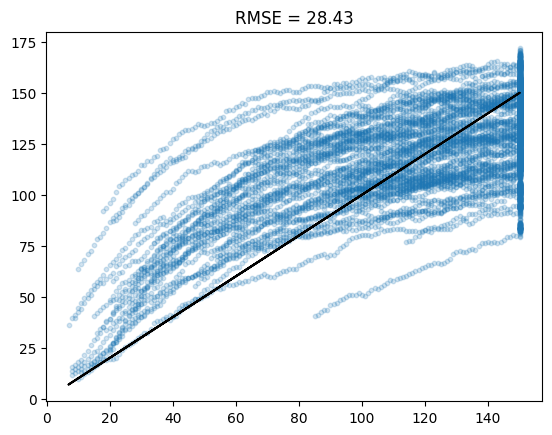

In [ ]:
y_test, yh_test = evaluate_full(model, test_loader, device)

plt.scatter(y_test, yh_test, s=10, alpha=0.2)
plt.plot(y_test, y_test, 'k')
plt.title(f'RMSE = {np.sqrt(mean_squared_error(y_test, yh_test)):.2f}')
plt.show()

# Evaluation on Last Cycle of Each Unit

In [ ]:
@torch.no_grad()
def evaluate_last_cycle(model, dataframe, device, feature_columns):
    model.eval()
    labels = []
    predictions = []
    for unit in dataframe.unit.unique():
        df_unit = dataframe.query(f'unit == {unit}')
        unit_dataset = TimeSeriesDataset(df_unit, feature_columns, 'unit', 'group', 'RUL')
        X, y = unit_dataset[-1]
        y_pred = model(X.unsqueeze(0).to(device))
        labels.append(y.item())
        predictions.append(y_pred.detach().cpu().item())
    return labels, predictions

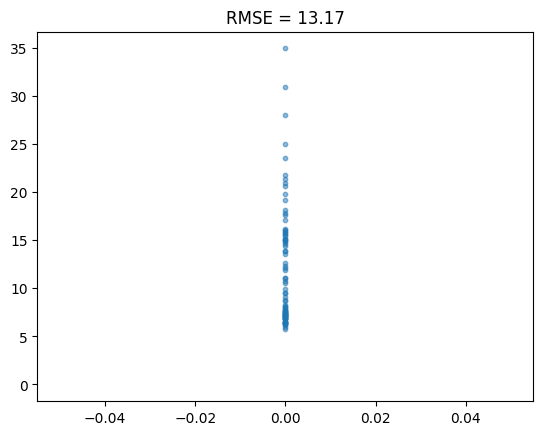

In [ ]:
y_train, yh_train = evaluate_last_cycle(model, train_df_norm, device, feature_columns)

plt.scatter(y_train, yh_train, s=10, alpha=0.5)
plt.plot(y_train, y_train, 'k')
plt.title(f'RMSE = {np.sqrt(mean_squared_error(y_train, yh_train)):.2f}')
plt.show()

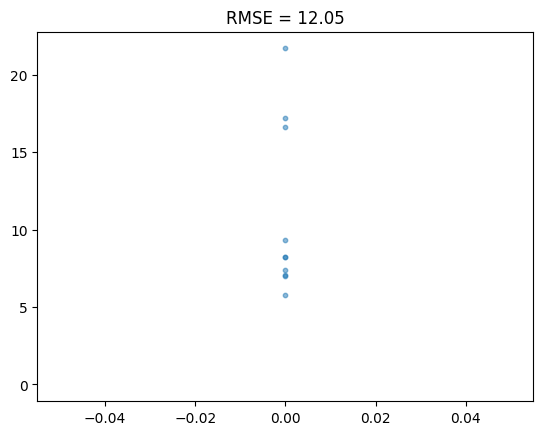

In [ ]:
y_val, yh_val = evaluate_last_cycle(model, val_df_norm, device, feature_columns)

plt.scatter(y_val, yh_val, s=10, alpha=0.5)
plt.plot(y_val, y_val, 'k')
plt.title(f'RMSE = {np.sqrt(mean_squared_error(y_val, yh_val)):.2f}')
plt.show()

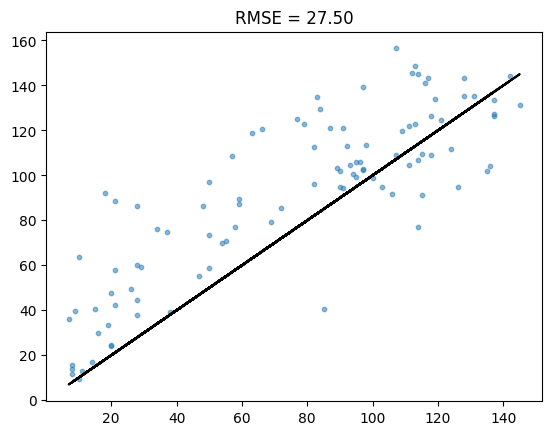

In [ ]:
y_test, yh_test = evaluate_last_cycle(model, test_df_norm, device, feature_columns)

plt.scatter(y_test, yh_test, s=10, alpha=0.5)
plt.plot(y_test, y_test, 'k')
plt.title(f'RMSE = {np.sqrt(mean_squared_error(y_test, yh_test)):.2f}')
plt.show()